# Twitter Sentiment Analysis - POC
---

## 7. Quickly train various models

**Current State**: I've trained two simple baseline models, Naive Bayes and Logistic Regression (liblinear), without much tweaking, on unigram Bag of Words (Bow) of  approximately $250k$ rows and $50k$ features. These simple models appear to be underfitting so throwing more data will not work. Naive Bayes achieved $77.6\%$ accuracy and Logistic Regression $78.8\%$.

**Next Steps**: Quickly train a variety of models and short-list a few promising models, based on the same BoW processed data. Starting with Stochastic Gradient Descent (SGD).

**Future Direction**: After short-listing models, I'll iterate on the representation and feature engineering steps and test the baseline models again for comparison. Ideally, I'd reiterate on testing all sorts of models since a new representation might incur in different results for different models.

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp

# SGD takes scaled data
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline

# models
from sklearn.linear_model import SGDClassifier

# evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

### Load *X_train_transformed* with $m\approx250k$ and $n=50k$

In [2]:
# time notebook
start_notebook = time.time()

# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")
X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_250k_50k.npz"))

In [3]:
X_train_transformed

<251468x50001 sparse matrix of type '<class 'numpy.int32'>'
	with 2569112 stored elements in Compressed Sparse Row format>

### Load y_array with $m\approx250k$

In [4]:
with open(os.path.join(proc_dir, "y_array_250k.npy"), 'rb') as f:
    y = np.load(f)

In [5]:
len(y), y[:10]

(251468, array([1, 1, 0, 0, 1, 1, 0, 0, 1, 0], dtype=int64))

### Stochastic Gradient Descent (SGD)

Chosen because it trains quickly. 

In [6]:
SGD_clf = make_pipeline(
                        StandardScaler(with_mean=False),
                        SGDClassifier(max_iter=1000, 
                                      tol=1e-3, 
                                      loss='hinge', # default, linear SVM, try 'log' for Logistic Regression
                                      warm_start=True,
                                      random_state=42, 
                                      n_jobs=-1)
                       )

In [7]:
# train
score = cross_val_score(SGD_clf, X_train_transformed, y, cv=5, verbose=3, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.740, total=  20.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.8s remaining:    0.0s


[CV] .................................... , score=0.738, total=  25.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.2s remaining:    0.0s


[CV] .................................... , score=0.735, total=  17.0s
[CV]  ................................................................
[CV] .................................... , score=0.743, total=  23.4s
[CV]  ................................................................
[CV] .................................... , score=0.737, total=  22.9s
Mean accuracy: 0.7384080782222016


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished


In [8]:
SGD_clf_log = make_pipeline(
                            StandardScaler(with_mean=False),
                            SGDClassifier(max_iter=1000, 
                                          tol=1e-3, 
                                          loss='log', # Logistic Regression
                                          warm_start=True,
                                          random_state=42, 
                                          n_jobs=-1)
                           )

score = cross_val_score(SGD_clf_log, X_train_transformed, y, cv=5, verbose=3, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.743, total=  46.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.0s remaining:    0.0s


[CV] .................................... , score=0.740, total=  38.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] .................................... , score=0.741, total=  38.1s
[CV]  ................................................................
[CV] .................................... , score=0.741, total=  31.7s
[CV]  ................................................................
[CV] .................................... , score=0.738, total=  43.4s
Mean accuracy: 0.7405514737046878


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min finished


In [9]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def plot_learning_curves_feed_m(model, X, y, Xname):
    """Plot the learning curves for train and validation sets
       , by adding more rows (m) and keeping the number of 
       features (n) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    # train
    # change data granularity (denominator) for more data points
    data_granularity = int(X_train.shape[0]/10)
    
    xs, train_acc, valid_acc = [], [], []

    for m in range(10, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, 
                       # dynamically calculate number of x ticks
                       round(X_train.shape[0]/data_granularity, 0), 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

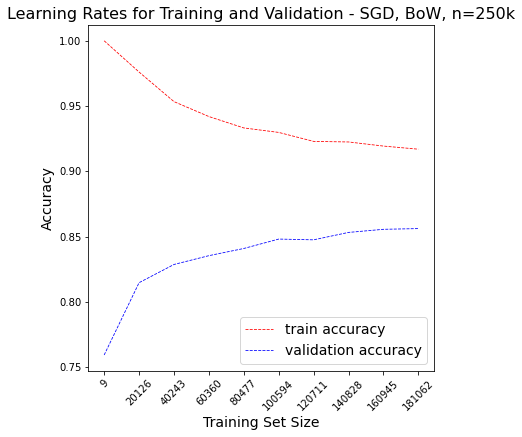

In [10]:
plot_learning_curves_feed_m(SGD_clf, X_train_transformed, y, 
                           'SGD, BoW, n=250k')

Interesting, as opposed to the simpler models, SGD actually seems to be on a path to improving classification and we should actually train it on the full $1.2M$ training dataset to see how far we can take this unigram BoW representation.

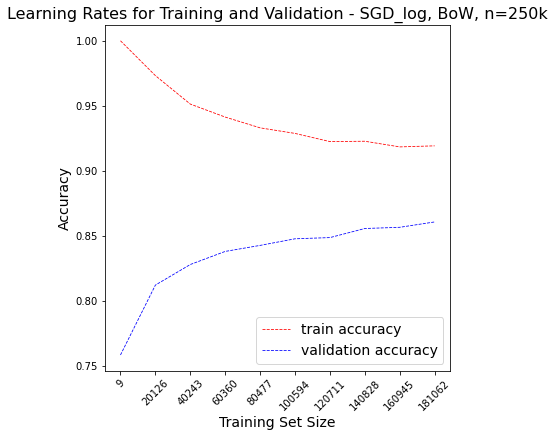

In [11]:
plot_learning_curves_feed_m(SGD_clf_log, X_train_transformed, y, 
                           'SGD_log, BoW, n=250k')

Logistic regression with SGD seems to be on an even better path as the validation accuracy seems to be improving at a steeper rate. 

In [12]:
import cleanup_module_POC as Cmod
from sklearn.pipeline import make_pipeline

In [13]:
raw_path = os.path.join("..","data","1_raw","sentiment140")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

In [14]:
# transform into arrays
X_array = np.array(X_train.iloc[:, 2]).ravel()
y_array = y_train.iloc[:,0].ravel()

In [15]:
try:
    # load X_train_transformed 
    X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_1200k_50k.npz"))
    print('Loading X_train_transformed...')
except:
    print('Preprocessing X_array as BoW...')
    preprocess_pipeline = Pipeline([
        ("document_to_wordcount", Cmod.DocumentToWordCounterTransformer()),
        ("wordcount_to_vector", Cmod.WordCounterToVectorTransformer(vocabulary_size=50000)), 
    ])
    start_pipeline = time.time()
    X_train_transformed = preprocess_pipeline.fit_transform(X_array)
    # save preprocessed data
    sp.save_npz(os.path.join(proc_dir, 'X_train_transformed_BoW_1200k_50k.npz'), X_train_transformed)
    # print processing time
    mins, secs = divmod(time.time() - start_pipeline, 60)
    print(f'Preprocessing time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')
    # Preprocessing time: 6 minute(s) and 17 second(s).

Loading X_train_transformed...


In [16]:
X_train_transformed

<1197471x50001 sparse matrix of type '<class 'numpy.int32'>'
	with 12223801 stored elements in Compressed Sparse Row format>

In [17]:
SGD_clf_log = make_pipeline(
                            StandardScaler(with_mean=False),
                            SGDClassifier(max_iter=5000, # increased just in case
                                          tol=1e-3, 
                                          loss='log', # Logistic Regression
                                          warm_start=True,
                                          random_state=42, 
                                          n_jobs=-1)
                           )

In [18]:
score = cross_val_score(SGD_clf_log, X_train_transformed, y_array, cv=5, verbose=4, scoring='accuracy')
print('Mean accuracy: ' + str(score.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.772, total= 2.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] .................................... , score=0.772, total= 2.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min remaining:    0.0s


[CV] .................................... , score=0.774, total= 2.8min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.0min remaining:    0.0s


[CV] .................................... , score=0.769, total= 2.2min
[CV]  ................................................................
[CV] .................................... , score=0.769, total= 2.4min
Mean accuracy: 0.770935579573944


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 12.6min finished


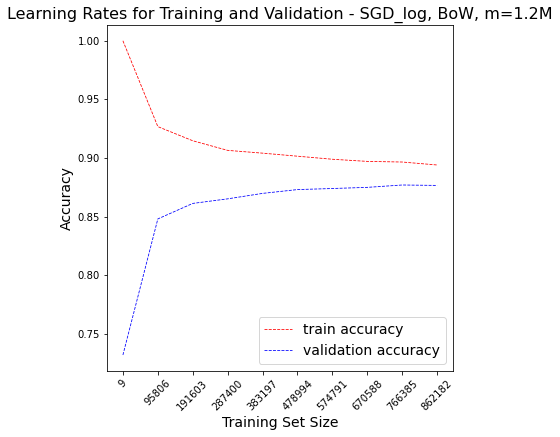

In [19]:
plot_learning_curves_feed_m(SGD_clf_log, X_train_transformed, y_array, 
                           'SGD_log, BoW, m=1.2M')

SGD converges at a low accuracy.

In [20]:
# time notebook
mins, secs = divmod(time.time() - start_notebook, 60)
print(f'Total running time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

Total running time: 39 minute(s) and 49 second(s).


---